In [1]:
# ================================
# Standard library
# ================================
import os
import re
from datetime import datetime
from pprint import pprint

# ================================
# Scientific computing
# ================================
import numpy as np
import pandas as pd
import scipy.stats as stats
from scipy.fft import fft, fftfreq
from scipy.signal import hilbert, welch
from scipy.sparse import coo_matrix

# ================================
# Machine learning - core
# ================================
import lightgbm as lgb
from xgboost import XGBRegressor

# ================================
# Machine learning - scikit-learn
# ================================
import joblib
from sklearn.ensemble import (
    ExtraTreesRegressor,
    GradientBoostingRegressor,
    HistGradientBoostingRegressor,
    RandomForestRegressor,
)
from sklearn.inspection import permutation_importance
from sklearn.linear_model import ElasticNet, Ridge
from sklearn.metrics import (
    confusion_matrix,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)
from sklearn.model_selection import (
    RandomizedSearchCV,
    cross_val_score,
    train_test_split,
)
from sklearn.neighbors import NearestNeighbors
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# ================================
# Progress bar
# ================================
from tqdm.auto import tqdm
from tqdm_joblib import tqdm_joblib


In [8]:
import sys
import os
import importlib

# aggiungi la root del progetto al PYTHONPATH
sys.path.append(os.path.abspath(".."))

In [6]:
# Converts relative paths to absolute ones
ROOT_TRAIN_DATA_FOLDER ='data/raw/Data_Challenge_PHM2023_training_data'
ROOT_TEST_DATA_FOLDER = 'data/raw/Data_Challenge_PHM2023_test_data'

## Parsing

In [10]:
import utils.parsing
importlib.reload(utils.parsing)
from utils.parsing import parse_vibration_dataset, parse_test_dataset

df = parse_vibration_dataset(ROOT_TRAIN_DATA_FOLDER)
test_df = parse_test_dataset(ROOT_TEST_DATA_FOLDER)


Trovati 2016 file .txt da processare


Parsing dataset: 100%|██████████| 2016/2016 [08:02<00:00,  4.18file/s]



Ordinamento dataset...
Dataset caricato: 2016 file processati
Health levels disponibili: [0, 1, 2, 3, 4, 6, 8]
Condizioni operative (rpm): [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1200, 2100, 2700, 3000, 3600]
Condizioni operative (torque): [50, 100, 200, 300, 400, 500]
Trovati 800 file .txt da processare


Parsing dataset: 100%|██████████| 800/800 [02:44<00:00,  4.87file/s]


Ordinamento dataset...
Dataset caricato: 800 file processati
Condizioni operative (rpm): [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1200, 1500, 1800, 2100, 2400, 2700, 3000, 3600]
Condizioni operative (torque): [50, 100, 200, 300, 400, 500]


In [11]:
df.to_pickle('data/processed/train_data.pkl')
test_df.to_pickle('data/processed/test_data.pkl')

In [ ]:
df

In [ ]:
test_df

## Downsampling

In [ ]:
df = pd.read_pickle('data/processed/train_data.pkl')

In [16]:
import utils.downsampling
importlib.reload(utils.downsampling)
from utils.downsampling import downsample_vibration_dataframe


features_df = downsample_vibration_dataframe(df, sec=3)

Preprocessing: 100%|██████████| 2016/2016 [00:00<00:00, 2381.90it/s]


In [ ]:
features_df.to_pickle('data/processed/train_data_dowsampled.pkl')

NameError: name 'features_df' is not defined

## Feature extraction

In [ ]:
features_df = pd.read_pickle("data/processed/train_data_dowsampled.pkl")

In [17]:
# -----------------------
# Pulizia base target
# -----------------------
features_df['health_level'] = pd.to_numeric(features_df['health_level'], errors='coerce')
features_df = features_df.dropna(subset=['health_level']).reset_index(drop=True)

# -----------------------
# Definisci colonne
# -----------------------
scalar_cols = ['velocita', 'torque']  # numeriche scalari già pronte
array_cols = ['horizontal_acceleration', 'axial_acceleration', 'vertical_acceleration', 'tachometer_signal']

scalar_cols = [c for c in scalar_cols if c in features_df.columns]
array_cols  = [c for c in array_cols  if c in features_df.columns]

In [19]:
import utils.feature_extraction
importlib.reload(utils.feature_extraction)
from utils.feature_extraction import expand_features, remove_multicollinearity

print("[*] Genero feature...")
X_with_features = expand_features(features_df, array_cols=array_cols, scalar_cols=scalar_cols)
y = features_df['health_level'].astype(float).values

X_with_features, dropped_cols = remove_multicollinearity(X_with_features, threshold=0.85)

print(f"[*] Shape X_with_features: {X_with_features.shape}, n_features = {X_with_features.shape[1]}")

[*] Genero feature...

📊 Rimozione multi-collinearità (threshold=0.85)...
   • Features iniziali: 75
   • Features rimosse: 39
   • Features rimanenti: 36
[*] Shape X_with_features: (2016, 36), n_features = 36


In [20]:
X_with_features

,ax_median,ax_skew,ax_kurt,ax_band_0_200,ax_band_200_500,ax_band_500_1000,ax_band_1000_2000,ax_band_2000_4000,ay_median,ay_skew,...,corr_xz,corr_yz,ipi_mean,ipi_std,ipi_cv,v_times_t,v_sq,t_sq,v_over_rpm,t_over_rpm
0,-0.136461,-0.776361,0.005485,0.008149,0.010712,0.015578,0.009459,0.022354,-0.151264,-0.770164,...,0.976064,0.971404,1.082007,0.000659,0.000609,5000,10000,2500,1.666667,0.833333
1,0.003846,-0.272321,-0.881175,0.006527,0.011009,0.015855,0.009479,0.021377,0.003531,-0.277709,...,0.978543,0.979238,1.082153,0.000220,0.000203,5000,10000,2500,1.666667,0.833333
2,0.003598,-0.276468,-0.882501,0.005376,0.010446,0.014623,0.008646,0.022393,0.003885,-0.290422,...,0.979485,0.979838,1.081201,0.000000,0.000000,5000,10000,2500,2.500000,1.250000
3,0.003101,-0.275950,-0.891065,0.006446,0.009653,0.014769,0.009171,0.021920,0.003296,-0.285690,...,0.980113,0.980239,1.082666,0.000000,0.000000,5000,10000,2500,2.500000,1.250000
4,0.003722,-0.278965,-0.880287,0.007915,0.009939,0.014594,0.008473,0.022195,0.003767,-0.286163,...,0.980032,0.980720,1.082373,0.000195,0.000180,5000,10000,2500,1.666667,0.833333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2011,0.005645,-0.013527,0.140991,0.002078,0.004298,0.036616,0.042241,0.306010,0.040200,-0.079874,...,-0.013338,0.307308,0.030001,0.000024,0.000802,180000,12960000,2500,1.800000,0.025000
2012,0.001116,-0.021760,0.110431,0.001955,0.004792,0.035701,0.042614,0.307787,0.039552,-0.065825,...,-0.001688,0.304524,0.030002,0.000024,0.000807,180000,12960000,2500,1.800000,0.025000
2013,0.004094,0.018121,0.038303,0.000846,0.003244,0.027520,0.069767,0.468692,-0.272392,0.226129,...,0.066381,0.463836,0.030002,0.000024,0.000807,360000,12960000,10000,1.800000,0.050000
2014,0.003349,0.019681,0.091883,0.000803,0.003702,0.029189,0.074510,0.469177,-0.256501,0.229332,...,0.048462,0.418718,0.030001,0.000024,0.000804,360000,12960000,10000,1.800000,0.050000


## Training

In [21]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

# -----------------------
# Split
# -----------------------
y_int = y.astype(int)
X = X_with_features.astype(np.float32).values

X_tr, X_va, y_tr, y_va = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y_int
)


print(f"Dataset: {len(y)} campioni, {X.shape[1]} features, {len(set(y))} classi")
print(f"Split: Train={len(y_tr)}, Val={len(y_va)}")

Dataset: 2016 campioni, 36 features, 7 classi
Split: Train=1612, Val=404


In [22]:
import utils.model_class
importlib.reload(utils.model_class)
from utils.model_class import ModelSelectorClassification

# 3. Inizializza e addestra il selettore
selector = ModelSelectorClassification(
    scoring="f1_macro",  # Usa F1 macro per classi sbilanciate
    cv_folds=3,
    random_state=42
)

# 4. Training di tutti i modelli
selector.fit(X_tr, y_tr)

TRAINING MODELLI (Classificazione)

[*] Tuning RandomForest...


Tuning RandomForest:   0%|          | 0/75 [00:00<?, ?it/s]

[+] Best F1_MACRO (cv) RandomForest: 0.9295
[+] Best params RandomForest:
{'model__class_weight': None,
 'model__max_depth': None,
 'model__max_features': 'log2',
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 600}

[*] Tuning HistGradientBoosting...


Tuning HistGradientBoosting:   0%|          | 0/75 [00:00<?, ?it/s]

[+] Best F1_MACRO (cv) HistGradientBoosting: 0.9262
[+] Best params HistGradientBoosting:
{'model__l2_regularization': 0.1,
 'model__learning_rate': 0.1,
 'model__max_depth': 8,
 'model__max_iter': 800,
 'model__min_samples_leaf': 30}

[*] Tuning XGBoost...


Tuning XGBoost:   0%|          | 0/90 [00:00<?, ?it/s]

[+] Best F1_MACRO (cv) XGBoost: 0.9167
[+] Best params XGBoost:
{'model__colsample_bytree': 0.9,
 'model__learning_rate': 0.05,
 'model__max_depth': 6,
 'model__n_estimators': 600,
 'model__reg_alpha': 0,
 'model__reg_lambda': 1.5,
 'model__subsample': 0.8}

[*] Tuning LightGBM...


Tuning LightGBM:   0%|          | 0/90 [00:00<?, ?it/s]

[+] Best F1_MACRO (cv) LightGBM: 0.9307
[+] Best params LightGBM:
{'model__class_weight': None,
 'model__colsample_bytree': 0.8,
 'model__learning_rate': 0.1,
 'model__max_depth': -1,
 'model__n_estimators': 600,
 'model__num_leaves': 31,
 'model__reg_alpha': 0,
 'model__reg_lambda': 0,
 'model__subsample': 0.9}

[*] Tuning GradientBoosting...


Tuning GradientBoosting:   0%|          | 0/75 [00:00<?, ?it/s]

[+] Best F1_MACRO (cv) GradientBoosting: 0.9398
[+] Best params GradientBoosting:
{'model__learning_rate': 0.1,
 'model__max_depth': 8,
 'model__max_features': 'sqrt',
 'model__n_estimators': 400,
 'model__subsample': 0.9}

[*] Tuning ExtraTrees...


Tuning ExtraTrees:   0%|          | 0/75 [00:00<?, ?it/s]

[+] Best F1_MACRO (cv) ExtraTrees: 0.9432
[+] Best params ExtraTrees:
{'model__class_weight': None,
 'model__max_depth': None,
 'model__max_features': 'log2',
 'model__min_samples_leaf': 1,
 'model__min_samples_split': 2,
 'model__n_estimators': 600}

[*] Tuning RidgeClassifier...


Tuning RidgeClassifier:   0%|          | 0/30 [00:00<?, ?it/s]

[+] Best F1_MACRO (cv) RidgeClassifier: 0.4986
[+] Best params RidgeClassifier:
{'model__alpha': 0.1, 'model__class_weight': 'balanced'}

[*] Tuning LogReg_ElasticNet...


Tuning LogReg_ElasticNet:   0%|          | 0/45 [00:00<?, ?it/s]

[+] Best F1_MACRO (cv) LogReg_ElasticNet: 0.6643
[+] Best params LogReg_ElasticNet:
{'model__C': 10.0, 'model__class_weight': 'balanced', 'model__l1_ratio': 0.7}

RISULTATI FINALI - CONFRONTO MODELLI (Cross-Validation)
Modello              Best CV F1_MACRO   Std       
-------------------------------------------------------
RandomForest         0.9295             0.0073    
HistGradientBoosting 0.9262             0.0108    
XGBoost              0.9167             0.0120    
LightGBM             0.9307             0.0066    
GradientBoosting     0.9398             0.0011    
ExtraTrees           0.9432             0.0025    
RidgeClassifier      0.4986             0.0298    
LogReg_ElasticNet    0.6643             0.0310    

🏆 Miglior modello (CV): ExtraTrees (F1_MACRO: 0.9432 ± 0.0025)


In [23]:
# Valutazione su validation set
val_results = selector.evaluate_all(X_va, y_va)


VALUTAZIONE SU VALIDATION - TUTTI I MODELLI

=== RandomForest on validation ===
Accuracy:            0.9802
Balanced Accuracy:   0.9792
F1 Macro:            0.9800
F1 Weighted:         0.9802
ROC AUC:             0.9991

=== HistGradientBoosting on validation ===
Accuracy:            0.9802
Balanced Accuracy:   0.9795
F1 Macro:            0.9800
F1 Weighted:         0.9801
ROC AUC:             0.9994

=== XGBoost on validation ===
Accuracy:            0.9777
Balanced Accuracy:   0.9769
F1 Macro:            0.9774
F1 Weighted:         0.9776
ROC AUC:             0.9992

=== LightGBM on validation ===
Accuracy:            0.9876
Balanced Accuracy:   0.9872
F1 Macro:            0.9874
F1 Weighted:         0.9876
ROC AUC:             0.9994

=== GradientBoosting on validation ===
Accuracy:            0.9851
Balanced Accuracy:   0.9846
F1 Macro:            0.9851
F1 Weighted:         0.9852
ROC AUC:             0.9999

=== ExtraTrees on validation ===
Accuracy:            0.9901
Balanced A

In [24]:
# Feature importance
importances = selector.feature_importance(X_va, y_va, n_repeats=10, top_k=10)


[*] Calcolo permutation importance sul modello ExtraTrees...

Top 10 feature (permutation importance - f1_macro):
30    0.008731
10    0.006695
20    0.006217
25    0.005885
24    0.005481
3     0.004492
26    0.004476
34    0.003743
11    0.003464
14    0.003441
dtype: float64


In [25]:
# Predizioni con il modello migliore
y_pred = selector.predict(X_va)
print("\nPredizioni di esempio:", y_pred[:10])


Predizioni di esempio: [0. 1. 3. 6. 8. 6. 2. 4. 2. 6.]


In [30]:

# Salvataggio del miglior modello
model_path, metadata_path = selector.save_model()

# Caricamento modello salvato
loaded_model, metadata = selector.load_model(model_path, metadata_path)
print("\nMetadata caricati:", metadata)

Modello salvato con joblib in: models/best_model_classification_ExtraTrees_20250829_185200.joblib
Metadati salvati in: models/best_model_classification_metadata_ExtraTrees_20250829_185200.json
Modello caricato da: models/best_model_classification_ExtraTrees_20250829_185200.joblib

Metadata caricati: {'model_name': 'ExtraTrees', 'scoring': 'f1_macro', 'accuracy': 0.9900990099009901, 'balanced_accuracy': 0.9894660894660895, 'f1_macro': 0.9899043985387717, 'f1_weighted': 0.9900836901595905, 'auc': 0.999678876557714, 'timestamp': '20250829_185200', 'best_params': {'model__n_estimators': 600, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_features': 'log2', 'model__max_depth': None, 'model__class_weight': None}, 'classes': [0.0, 1.0, 2.0, 3.0, 4.0, 6.0, 8.0]}


In [26]:
# Creazione di un ensemble dei top 3
ensemble = selector.create_ensemble(top_n=3, voting='soft')

# Addestriamo l’ensemble sulle stesse feature
ensemble.fit(X_tr, y_tr)
print("\nAccuracy ensemble:", ensemble.score(X_va, y_va))


[*] Creato ensemble con soft voting dei top 3 modelli:
  • ExtraTrees
  • GradientBoosting
  • LightGBM

Accuracy ensemble: 0.9900990099009901


In [ ]:
# Salvataggio del miglior modello
model_path_ensamble, metadata_path_ensamble = selector.save_model()

Modello salvato con joblib in: models/best_model_classification_ensemble_model_20250829_184740.joblib


StopIteration: 

## Testing

In [ ]:
test_df = pd.read_pickle('data/processed/test_data.pkl')

In [31]:
array_cols = ['horizontal_acceleration', 'axial_acceleration', 'vertical_acceleration', 'tachometer_signal']
scalar_cols = ['velocita', 'torque'] 
X_te = expand_features(test_df, array_cols=array_cols, scalar_cols=scalar_cols)
X_te = X_te.drop(columns=dropped_cols, errors='ignore')

In [32]:
best_model = joblib.load('models/best_model_classification_ensemble_model_20250829_184740.joblib')

In [34]:
import utils.testing_class
importlib.reload(utils.testing_class)
from utils.testing_class import TestingClass

gen = TestingClass(debug=True)   # debug=True per log più dettagliati

submission_df, diagnostics = gen.create_submission_simple(
    X_tr=X_tr,
    y_tr=y_tr,
    X_test=X_te,
    test_df=test_df,
    best_model=best_model,
    conf_thresh=0.3,       # soglia di confidence
    ordinal_smooth=0.05    # smoothing ordinale
)

# -------------------------
# 4) Risultati
# -------------------------
print("Submission:")
print(submission_df.head())

print("\nDiagnostics:")
for k, v in diagnostics.items():
    print(f"{k}: {v}")


Model detected: VotingClassifier
Has scaler in pipeline: False
Requires scaling: False
Using RAW data for model predictions

=== DIAGNOSTICS ===

model_info:
{'name': 'VotingClassifier', 'has_scaler': False, 'requires_scaling': False, 'input_scaled': False}

detectors_info:
{'thresholds': {4: 0.02003315028603996, 6: 0.0188664904138649, 8: 0.014513829856696936}, 'n_detectors': 3}

tail_info:
{'strategy': 'adaptive', 'q85': 0.025478637467128994, 'q95': 4.504860026677271e-17, 'q99': -0.027386035375744577, 'mean': 0.08251335154599104, 'std': 0.043131412725069776}

transfers:
{'4_to_5': {'n_transfers': 8, 'total_moved': 2.2587486667195114, 'avg_alpha': 0.3764133501982634, 'alpha_range': '0.084-0.573'}, '6_to_7': {'n_transfers': 8, 'total_moved': 2.150342173851355, 'avg_alpha': 0.46233195626867374, 'alpha_range': '0.153-0.614'}, '8_to_10': {'n_transfers': 21, 'total_moved': 10.607232289978198, 'avg_alpha': 0.5913920044665761}, '8_to_9': {'n_transfers': 21, 'total_moved': 8.301864389314323, '

Submission:
    id    prob_0    prob_1    prob_2    prob_3    prob_4        prob_5  \
0  253  0.004981  0.001125  0.000297  0.062424  0.924837  4.669419e-03   
1  271  0.011522  0.968038  0.006061  0.014306  0.000072  1.033960e-10   
2  337  0.046245  0.012530  0.076932  0.005910  0.002792  1.409725e-05   
3  457  0.001658  0.000008  0.000086  0.021951  0.970285  4.899994e-03   
4  476  0.014295  0.969702  0.006047  0.009906  0.000050  1.105285e-10   

         prob_6        prob_7        prob_8        prob_9   prob_10  \
0  4.297411e-09  8.333764e-06  1.650081e-03  8.333742e-06  0.000000   
1  4.363544e-09  9.499015e-11  1.444450e-08  7.295204e-11  0.000000   
2  2.718878e-05  1.605053e-03  3.204461e-01  5.308266e-01  0.002673   
3  1.488516e-09  5.555640e-06  1.100015e-03  5.555632e-06  0.000000   
4  4.618571e-09  9.665128e-11  1.451838e-08  7.332517e-11  0.000000   

   confidence  
0           1  
1           1  
2           1  
3           1  
4           1  

Diagnostics:
model_

### Results

Loaded backend module://matplotlib_inline.backend_inline version unknown.
Loaded backend module://matplotlib_inline.backend_inline version unknown.
findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
findfont: score(FontEntry(fname='c:\\Users\\dswal\\anaconda3\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='c:\\Users\\dswal\\anaconda3\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSerif-Bold.ttf', name='DejaVu Serif', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='c:\\Users\\dswal\\anaconda3\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSerif-BoldItalic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 

Eseguendo analisi completa della submission...
ANALISI SUBMISSION
📊 STATISTICHE GENERALI:
   • Numero predizioni: 800
   • Confidence alta: 765 (95.6%)
   • Range somma probabilità: [1.000000, 1.000000]
   ✅ Tutte le probabilità sono normalizzate

📈 DISTRIBUZIONE PREDIZIONI:
   • Classe 0:    63 (  7.9%)
   • Classe 1:    84 ( 10.5%)
   • Classe 2:    56 (  7.0%)
   • Classe 3:    59 (  7.4%)
   • Classe 4:    66 (  8.2%)
   • Classe 6:   178 ( 22.2%)
   • Classe 8:   270 ( 33.8%)
   • Classe 9:     9 (  1.1%)
   • Classe 10:    15 (  1.9%)

🎯 CLASSI MANCANTI (5, 7, 9):
   • Probabilità totale trasferita: 17.0730
   • Classe 5: prob_sum= 3.3814, predizioni=   0
   • Classe 7: prob_sum= 4.1701, predizioni=   0
   • Classe 9: prob_sum= 9.5215, predizioni=   9

🎯 ANALISI CONFIDENCE:
   • High confidence: media max_prob = 0.787
   • Low confidence:  media max_prob = 0.387

Creando visualizzazioni...


findfont: score(FontEntry(fname='c:\\Users\\dswal\\anaconda3\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXGeneralBolIta.ttf', name='STIXGeneral', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
findfont: score(FontEntry(fname='c:\\Users\\dswal\\anaconda3\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXSizFourSymBol.ttf', name='STIXSizeFourSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
findfont: score(FontEntry(fname='c:\\Users\\dswal\\anaconda3\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\cmex10.ttf', name='cmex10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(FontEntry(fname='c:\\Users\\dswal\\anaconda3\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\STIXGeneral.ttf', name='STIXGeneral', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
findfont: score(

KeyboardInterrupt: 

vmin 6.258884211561738e-14 vmax 2.1907529983201472
ticklocs array([1.e-16, 1.e-14, 1.e-12, 1.e-10, 1.e-08, 1.e-06, 1.e-04, 1.e-02,
       1.e+00, 1.e+02, 1.e+04])
vmin 6.258884211561738e-14 vmax 2.1907529983201472
vmin 6.258884211561738e-14 vmax 2.1907529983201472
ticklocs array([1.e-16, 1.e-14, 1.e-12, 1.e-10, 1.e-08, 1.e-06, 1.e-04, 1.e-02,
       1.e+00, 1.e+02, 1.e+04])
vmin 6.258884211561738e-14 vmax 2.1907529983201472
ticklocs array([1.e-16, 1.e-14, 1.e-12, 1.e-10, 1.e-08, 1.e-06, 1.e-04, 1.e-02,
       1.e+00, 1.e+02, 1.e+04])
vmin 6.258884211561738e-14 vmax 2.1907529983201472
vmin 6.258884211561738e-14 vmax 2.1907529983201472
ticklocs array([1.e-16, 1.e-14, 1.e-12, 1.e-10, 1.e-08, 1.e-06, 1.e-04, 1.e-02,
       1.e+00, 1.e+02, 1.e+04])
findfont: Matching cmex10:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
findfont: score(FontEntry(fname='c:\\Users\\dswal\\anaconda3\\Lib\\site-packages\\matplotlib\\mpl-data\\fonts\\ttf\\DejaVuSansMono.ttf', name='DejaVu Sa

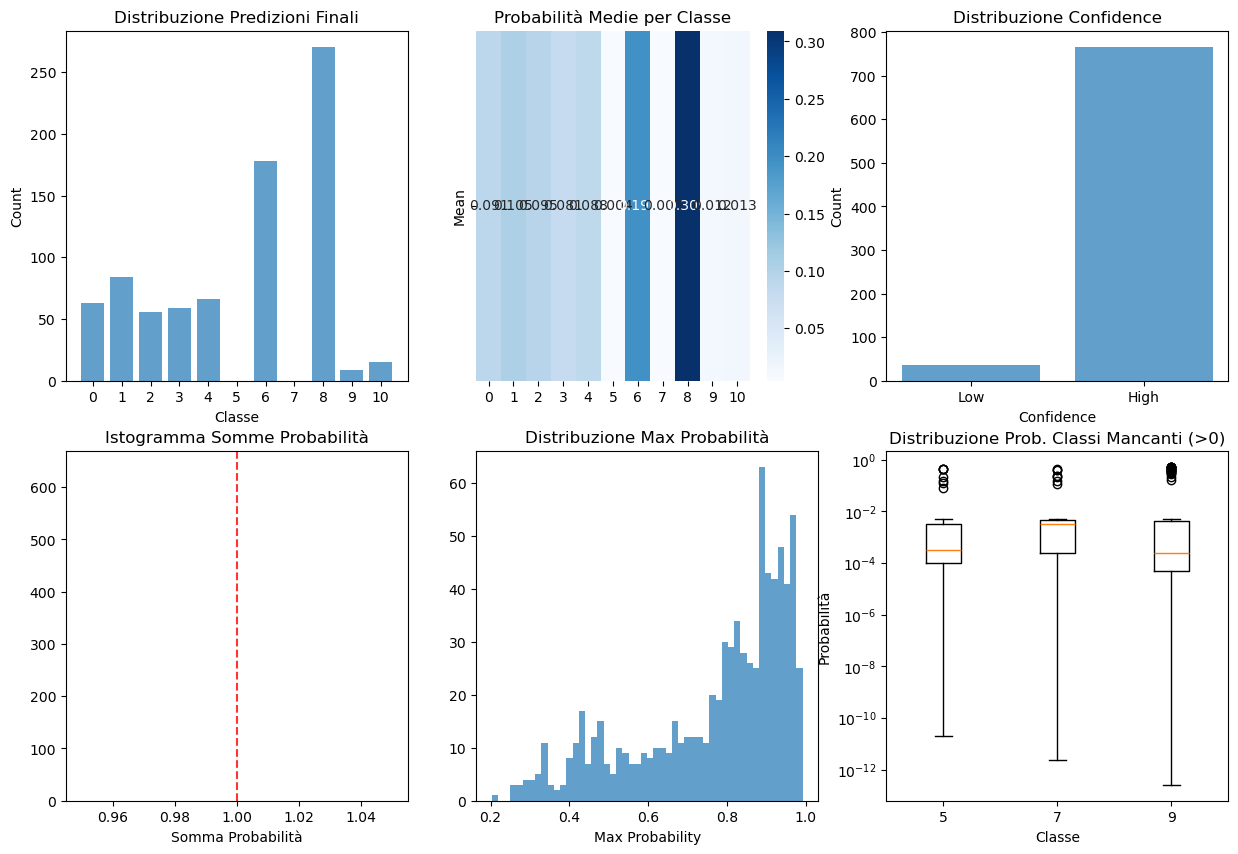

In [36]:
# ============================================
# ANALISI E VALIDAZIONE SUBMISSION
# ============================================

import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------
# 1) ANALISI DELLE PROBABILITÀ
# -------------------------
def analyze_submission(probs_df, y_tr=None):
    print("=" * 60)
    print("ANALISI SUBMISSION")
    print("=" * 60)
    
    # Statistiche base
    prob_cols = [f"prob_{i}" for i in range(11)]
    
    print(f"📊 STATISTICHE GENERALI:")
    print(f"   • Numero predizioni: {len(probs_df)}")
    print(f"   • Confidence alta: {probs_df['confidence'].sum()} ({probs_df['confidence'].mean():.1%})")
    
    # Verifica normalizzazione
    prob_sums = probs_df[prob_cols].sum(axis=1)
    print(f"   • Range somma probabilità: [{prob_sums.min():.6f}, {prob_sums.max():.6f}]")
    if not np.allclose(prob_sums, 1.0, rtol=1e-4):
        print("   ⚠️  Alcune righe non sono perfettamente normalizzate!")
    else:
        print("   ✅ Tutte le probabilità sono normalizzate")
    
    # Distribuzione predizioni
    y_pred = probs_df[prob_cols].values.argmax(axis=1)
    unique, counts = np.unique(y_pred, return_counts=True)
    
    print(f"\n📈 DISTRIBUZIONE PREDIZIONI:")
    for cls, cnt in zip(unique, counts):
        pct = cnt / len(probs_df) * 100
        print(f"   • Classe {cls}: {cnt:5d} ({pct:5.1f}%)")
    
    # Focus su classi mancanti
    missing_classes = [5, 7, 9]
    total_missing = sum(probs_df[f"prob_{c}"].sum() for c in missing_classes)
    print(f"\n🎯 CLASSI MANCANTI (5, 7, 9):")
    print(f"   • Probabilità totale trasferita: {total_missing:.4f}")
    for c in missing_classes:
        prob_sum = probs_df[f"prob_{c}"].sum()
        pred_count = (y_pred == c).sum()
        print(f"   • Classe {c}: prob_sum={prob_sum:7.4f}, predizioni={pred_count:4d}")
    
    # Analisi confidence
    high_conf = probs_df[probs_df['confidence'] == 1]
    low_conf = probs_df[probs_df['confidence'] == 0]
    
    print(f"\n🎯 ANALISI CONFIDENCE:")
    if len(high_conf) > 0:
        max_probs_high = high_conf[prob_cols].max(axis=1)
        print(f"   • High confidence: media max_prob = {max_probs_high.mean():.3f}")
    if len(low_conf) > 0:
        max_probs_low = low_conf[prob_cols].max(axis=1)
        print(f"   • Low confidence:  media max_prob = {max_probs_low.mean():.3f}")
    
    return y_pred, prob_sums

# -------------------------
# 2) VISUALIZZAZIONI
# -------------------------
def plot_submission_analysis(probs_df, figsize=(15, 10)):
    prob_cols = [f"prob_{i}" for i in range(11)]
    y_pred = probs_df[prob_cols].values.argmax(axis=1)
    
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    axes = axes.ravel()
    
    # 1) Distribuzione predizioni
    unique, counts = np.unique(y_pred, return_counts=True)
    axes[0].bar(unique, counts, alpha=0.7)
    axes[0].set_title('Distribuzione Predizioni Finali')
    axes[0].set_xlabel('Classe')
    axes[0].set_ylabel('Count')
    axes[0].set_xticks(range(11))
    
    # 2) Heatmap probabilità medie per classe
    mean_probs = probs_df[prob_cols].mean().values.reshape(1, -1)
    sns.heatmap(mean_probs, annot=True, fmt='.3f', 
                xticklabels=range(11), yticklabels=['Mean'], 
                ax=axes[1], cmap='Blues')
    axes[1].set_title('Probabilità Medie per Classe')
    
    # 3) Confidence distribution
    conf_counts = probs_df['confidence'].value_counts()
    axes[2].bar(conf_counts.index, conf_counts.values, alpha=0.7)
    axes[2].set_title('Distribuzione Confidence')
    axes[2].set_xlabel('Confidence')
    axes[2].set_ylabel('Count')
    axes[2].set_xticks([0, 1])
    axes[2].set_xticklabels(['Low', 'High'])
    
    # 4) Prob sum histogram
    prob_sums = probs_df[prob_cols].sum(axis=1)
    axes[3].hist(prob_sums, bins=50, alpha=0.7)
    axes[3].set_title('Istogramma Somme Probabilità')
    axes[3].set_xlabel('Somma Probabilità')
    axes[3].axvline(1.0, color='red', linestyle='--', alpha=0.8)
    
    # 5) Max probability distribution
    max_probs = probs_df[prob_cols].max(axis=1)
    axes[4].hist(max_probs, bins=50, alpha=0.7)
    axes[4].set_title('Distribuzione Max Probabilità')
    axes[4].set_xlabel('Max Probability')
    
    # 6) Missing classes focus
    missing_cols = ['prob_5', 'prob_7', 'prob_9']
    missing_data = probs_df[missing_cols].values
    
    # Filtra valori > 0 per il log scale
    missing_data_filtered = []
    labels_filtered = []
    for i, col in enumerate([5, 7, 9]):
        data_col = missing_data[:, i]
        data_positive = data_col[data_col > 0]
        if len(data_positive) > 0:
            missing_data_filtered.append(data_positive)
            labels_filtered.append(str(col))
    
    if missing_data_filtered:
        axes[5].boxplot(missing_data_filtered, labels=labels_filtered)
        axes[5].set_title('Distribuzione Prob. Classi Mancanti (>0)')
        axes[5].set_xlabel('Classe')
        axes[5].set_ylabel('Probabilità')
        axes[5].set_yscale('log')
    else:
        # Se non ci sono valori > 0, mostra un barplot semplice
        missing_sums = probs_df[missing_cols].sum().values
        axes[5].bar([5, 7, 9], missing_sums, alpha=0.7)
        axes[5].set_title('Somma Prob. Classi Mancanti')
        axes[5].set_xlabel('Classe')
        axes[5].set_ylabel('Somma Probabilità')
    
    plt.tight_layout()
    plt.show()

# -------------------------
# 3) VALIDAZIONE FINALE
# -------------------------
def validate_submission(probs_df):
    print("=" * 60)
    print("VALIDAZIONE FINALE SUBMISSION")
    print("=" * 60)
    
    prob_cols = [f"prob_{i}" for i in range(11)]
    issues = []
    
    # 1) Check colonne obbligatorie
    required_cols = ['id'] + prob_cols + ['confidence']
    missing_cols = [c for c in required_cols if c not in probs_df.columns]
    if missing_cols:
        issues.append(f"❌ Colonne mancanti: {missing_cols}")
    else:
        print("✅ Tutte le colonne richieste presenti")
    
    # 2) Check valori probabilità
    probs_matrix = probs_df[prob_cols].values
    if np.any(probs_matrix < 0):
        issues.append("❌ Alcune probabilità sono negative")
    else:
        print("✅ Tutte le probabilità sono non-negative")
    
    if np.any(probs_matrix > 1):
        issues.append("❌ Alcune probabilità sono > 1")
    else:
        print("✅ Tutte le probabilità sono ≤ 1")
    
    # 3) Check normalizzazione
    prob_sums = probs_matrix.sum(axis=1)
    if not np.allclose(prob_sums, 1.0, rtol=1e-4):
        issues.append(f"❌ Normalizzazione: range [{prob_sums.min():.6f}, {prob_sums.max():.6f}]")
    else:
        print("✅ Probabilità correttamente normalizzate")
    
    # 4) Check confidence
    conf_values = probs_df['confidence'].unique()
    if not set(conf_values).issubset({0, 1}):
        issues.append(f"❌ Confidence deve essere 0 o 1, trovati: {conf_values}")
    else:
        print("✅ Valori confidence corretti (0 o 1)")
    
    # 5) Check ID duplicati
    if probs_df['id'].duplicated().any():
        issues.append("❌ ID duplicati trovati")
    else:
        print("✅ Nessun ID duplicato")
    
    # 6) Summary
    if issues:
        print(f"\n⚠️  PROBLEMI TROVATI ({len(issues)}):")
        for issue in issues:
            print(f"   {issue}")
        return False
    else:
        print(f"\n🎉 SUBMISSION VALIDA!")
        print(f"   • Shape: {probs_df.shape}")
        print(f"   • Range ID: [{probs_df['id'].min()}, {probs_df['id'].max()}]")
        return True

# -------------------------
# 4) ANALISI COMPLETA
# -------------------------
print("Eseguendo analisi completa della submission...")

# Analisi statistiche
y_pred, prob_sums = analyze_submission(submission_df, y_tr)

# Visualizzazioni
print(f"\nCreando visualizzazioni...")
plot_submission_analysis(submission_df)

# Validazione finale
is_valid = validate_submission(submission_df)

if is_valid:
    print(f"\n💾 Pronto per salvare:")
    print(f"probs_df.to_csv('submission.csv', index=False)")
    
    # Statistiche finali utili
    print(f"\n📋 STATISTICHE FINALI:")
    missing_pred = sum((y_pred == c).sum() for c in [5, 7, 9])
    print(f"   • Predizioni classi mancanti: {missing_pred} / {len(submission_df)} ({missing_pred/len(submission_df):.1%})")
    
    base_pred = sum((y_pred == c).sum() for c in [4, 6, 8])
    print(f"   • Predizioni classi base (4,6,8): {base_pred} / {len(submission_df)} ({base_pred/len(submission_df):.1%})")
else:
    print(f"\n🔧 Correggi i problemi prima di procedere con la submission.")